In [1]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
library("MuMIn")
library("plyr")
library("knitr")

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

   

In [2]:
#Load the data => Here, we are filtering the cases in which subjects had a MuIFI of 0
FinalPath<-'../ToInput/R_HumanMod_MS17.txt'
data <- read.delim(FinalPath, sep="\t", header=T, stringsAsFactors=F)
data <- data %>% filter(!NewTracker=='no')
#dataTest <- data
data$lCV <- log(data$CV)
head(data,15)

,Agent,Subject,condition1,condition2,GameNb,Points,Entropy,Periodicity,Amplitude,MuIFI,StdIFI,CV,Resets,Deflations,Misses,GameSpeed,NewTracker,lCV
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,Human,A1H5I0BGVIY5CC,slow,slow,1,0,4.754888,0,0.00000000,0.000,0.0000,0.0000000,53,5,3,SSS,Human,-Inf
2,Human,A1H5I0BGVIY5CC,slow,slow,2,876,4.031359,1248,0.02126137,2548.355,2098.1992,0.8233544,4,10,5,SSS,Human,-0.1943685
3,Human,A1H5I0BGVIY5CC,slow,slow,3,1164,3.680692,1152,0.16175389,1491.830,643.3786,0.4312681,7,7,6,SSS,Human,-0.8410253
4,Human,A1H5I0BGVIY5CC,slow,slow,4,0,4.754888,0,0.00000000,0.000,0.0000,0.0000000,19,4,5,SSS,Human,-Inf
5,Human,A1H5I0BGVIY5CC,slow,slow,5,0,4.754888,0,0.00000000,0.000,0.0000,0.0000000,18,4,7,SSS,Human,-Inf
6,Human,A1H5I0BGVIY5CC,slow,slow,6,1188,3.706067,1152,0.10679609,1354.912,533.3642,0.3936523,8,1,6,SSS,Human,-0.9322872
7,Human,A1H5I0BGVIY5CC,slow,slow,7,1182,3.750739,1072,0.02100682,1534.550,605.2312,0.3944030,5,5,5,SSS,Human,-0.9303819
8,Human,A1H5I0BGVIY5CC,slow,slow,8,2070,3.772847,1280,0.07723494,1557.833,494.2271,0.3172529,0,2,5,SSS,Human,-1.1480561
9,Human,A1H5I0BGVIY5CC,slow,slow,9,2094,3.365619,1248,0.07976081,1470.068,372.2022,0.2531871,0,1,2,SSS,Human,-1.3736264


In [3]:
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [4]:
table(data$Agent, data$GameSpeed)

       
         MMM  MSM  SMS  SSS
  Human  300  300  300  300
  Model 1500 1500 1500 1500

In [5]:
#Getting data for games 1-5
NewData <- data
n_games <- 15
for(i in 6:15){
    NewData <- NewData %>% filter(GameNb!=i)
}

In [6]:
table(NewData$Agent, NewData$GameSpeed)

       
        MMM MSM SMS SSS
  Human 100 100 100 100
  Model 500 500 500 500

In [7]:
#Creating dataset for Human games 1-5
MMM <- (NewData %>% filter(Agent=="Human") %>% filter(GameSpeed=="MMM"))$Points
MSM <- (NewData %>% filter(Agent=="Human") %>% filter(GameSpeed=="MSM"))$Points
SMS <- (NewData %>% filter(Agent=="Human") %>% filter(GameSpeed=="SMS"))$Points
SSS <- (NewData %>% filter(Agent=="Human") %>% filter(GameSpeed=="SSS"))$Points
H1_5 <- data.frame(MMM,MSM,SMS,SSS)
nrow(H1_5)
head(H1_5,10)

[1] 100

,MMM,MSM,SMS,SSS
,<dbl>,<dbl>,<dbl>,<dbl>
1,2364,148,1200,0
2,3168,1548,1794,876
3,3356,1972,1788,1164
4,2564,2384,2088,0
5,2564,2380,2688,0
6,1532,1916,1794,600
7,2716,2540,1794,1794
8,2732,2932,2394,2082
9,3132,2940,2388,2094


In [8]:
#Creating dataset for Model games 1-5
MMM <- (NewData %>% filter(Agent=="Model") %>% filter(GameSpeed=="MMM"))$Points
MSM <- (NewData %>% filter(Agent=="Model") %>% filter(GameSpeed=="MSM"))$Points
SMS <- (NewData %>% filter(Agent=="Model") %>% filter(GameSpeed=="SMS"))$Points
SSS <- (NewData %>% filter(Agent=="Model") %>% filter(GameSpeed=="SSS"))$Points
M1_5 <- data.frame(MMM,MSM,SMS,SSS)
nrow(M1_5)
head(M1_5,10)

[1] 500

,MMM,MSM,SMS,SSS
,<dbl>,<dbl>,<dbl>,<dbl>
1,1908,724,1050,1122
2,2468,1700,1716,1458
3,2312,2536,1410,2034
4,2332,2092,1164,1728
5,2316,2960,2004,1164
6,820,1516,1740,264
7,1908,1596,1704,270
8,1636,2104,2016,270
9,1940,2740,1752,870


In [9]:
#Getting means for games 6-10
Data6_10 <- data
n_games <- 15
for(i in 1:5){
    Data6_10 <- Data6_10 %>% filter(GameNb!=i)
}
for(i in 11:15){
    Data6_10 <- Data6_10 %>% filter(GameNb!=i)
}
table(Data6_10$Agent, Data6_10$GameSpeed)

       
        MMM MSM SMS SSS
  Human 100 100 100 100
  Model 500 500 500 500

In [10]:
#Creating dataset for Human games 6-10
MMM <- (Data6_10 %>% filter(Agent=="Human") %>% filter(GameSpeed=="MMM"))$Points
MSM <- (Data6_10 %>% filter(Agent=="Human") %>% filter(GameSpeed=="MSM"))$Points
SMS <- (Data6_10 %>% filter(Agent=="Human") %>% filter(GameSpeed=="SMS"))$Points
SSS <- (Data6_10 %>% filter(Agent=="Human") %>% filter(GameSpeed=="SSS"))$Points
H6_10 <- data.frame(MMM,MSM,SMS,SSS)
nrow(H6_10)
head(H6_10,10)

[1] 100

,MMM,MSM,SMS,SSS
,<dbl>,<dbl>,<dbl>,<dbl>
1,2952,1170,2588,1188
2,3360,2070,2992,1182
3,3368,2094,3176,2070
4,3336,2394,3160,2094
5,3576,2382,2984,1800
6,2924,2082,2160,2394
7,2936,2082,2784,2400
8,3328,2094,2552,2394
9,2904,2376,2984,2400


In [11]:
#Creating dataset for Model games 6-10
MMM <- (Data6_10 %>% filter(Agent=="Model") %>% filter(GameSpeed=="MMM"))$Points
MSM <- (Data6_10 %>% filter(Agent=="Model") %>% filter(GameSpeed=="MSM"))$Points
SMS <- (Data6_10 %>% filter(Agent=="Model") %>% filter(GameSpeed=="SMS"))$Points
SSS <- (Data6_10 %>% filter(Agent=="Model") %>% filter(GameSpeed=="SSS"))$Points
M6_10 <- data.frame(MMM,MSM,SMS,SSS)
nrow(M6_10)
head(M6_10,10)

[1] 500

,MMM,MSM,SMS,SSS
,<dbl>,<dbl>,<dbl>,<dbl>
1,1940,1794,1732,1440
2,2752,2322,2324,2088
3,2376,2376,2532,2052
4,2352,2004,2956,2328
5,3148,1122,2936,2034
6,2932,2076,2548,876
7,2576,1464,2536,1128
8,2956,2046,2968,588
9,2948,2076,2972,300


In [12]:
Transfer <- function(H1_5,H6_10,M1_5,M6_10) {
    #Humans
    Slow_H1 <- (mean(H1_5$SMS) + mean(H1_5$SSS))/2
    Med_H1 <- (mean(H1_5$MSM)+mean(H1_5$MMM))/2
    Slow_H6 <- (mean(H6_10$MSM)+mean(H6_10$SSS))/2
    Med_H6 <- (mean(H6_10$SMS)+mean(H6_10$MMM))/2

    SSS_H1 <- mean(H1_5$SSS)
    MMM_H1 <- mean(H1_5$MMM)
    SMS_H1 <- mean(H1_5$SMS)
    MSM_H1 <- mean(H1_5$MSM)
    
    MSM_H6 <- mean(H6_10$MSM)
    SMS_H6 <- mean(H6_10$SMS)
    SSS_H6 <- mean(H6_10$SSS)
    MMM_H6 <- mean(H6_10$MMM)
    #Models
    Slow_M1 <- (mean(M1_5$SMS) + mean(M1_5$SSS))/2
    Med_M1 <- (mean(M1_5$MSM)+mean(M1_5$MMM))/2
    Slow_M6 <- (mean(M6_10$MSM)+mean(M6_10$SSS))/2
    Med_M6 <- (mean(M6_10$SMS)+mean(M6_10$MMM))/2

    SSS_M1 <- mean(M1_5$SSS)
    MMM_M1 <- mean(M1_5$MMM)
    SMS_M1 <- mean(M1_5$SMS)
    MSM_M1 <- mean(M1_5$MSM)
    
    MSM_M6 <- mean(M6_10$MSM)
    SMS_M6 <- mean(M6_10$SMS)
    SSS_M6 <- mean(M6_10$SSS)
    MMM_M6 <- mean(M6_10$MMM)
    
    Tr1 <- c(0,0,0,0)
    Tr2 <- c(0,0,0,0)
    Tr3 <- c(0,0,0,0)
    #Transfer calculations - Transfer 1
    #Tr1 = [Human_Slow,Human_Medium,Model_Slow,Model_Medium]
    #Compute Transfer measures - Humans SSS/MMM 1-5
    Tr1[1] <- ((MSM_H6 - Slow_H1)/Slow_H1)*100
    Tr1[2] <- ((SMS_H6 - Med_H1)/Med_H1)*100
    #Compute Transfer measures now - Models SSS/MMM 1-5
    Tr1[3] <- ((MSM_M6 - Slow_M1)/Slow_M1)*100
    Tr1[4] <- ((SMS_M6 - Med_M1)/Med_M1)*100 
    
    #Transfer 2
    #Tr2 = [Human_Slow,Human_Medium,Model_Slow,Model_Medium]
    #Compute Transfer measures - Humans SSS/MMM 6-10
    Tr2[1] <- ((MSM_H6 - Slow_H1)/SSS_H6)*100
    Tr2[2] <- ((SMS_H6 - Med_H1)/MMM_H6)*100
    #Compute Transfer measures now - Models SSS/MMM 6-10
    Tr2[3] <- ((MSM_M6 - Slow_M1)/SSS_M6)*100
    Tr2[4] <- ((SMS_M6 - Med_M1)/MMM_M6)*100
    
    #Transfer 3
    #Tr3 = [Human_Slow,Human_Medium,Model_Slow,Model_Medium]
    #Compute Transfer measures - Humans difference
    Tr3[1] <- ((MSM_H6 - Slow_H1)/(SSS_H6-Slow_H1))*100
    Tr3[2] <- ((SMS_H6 - Med_H1)/(MMM_H6-Med_H1))*100
    #Compute Transfer measures now - Models difference
    Tr3[3] <- ((MSM_M6 - Slow_M1)/(SSS_M6-Slow_M1))*100
    Tr3[4] <- ((SMS_M6 - Med_M1)/(MMM_M6-Med_M1))*100
    
    toReturn <- c(Tr1,Tr2,Tr3) # 4 first are first transfer, 4 second are second transfer, 4 last are last transfer
    return(toReturn)
}

In [13]:
print(Transfer(H1_5,H6_10,M1_5,M6_10))

 [1]  21.80189  27.58321  24.98736  24.80937  16.95286  22.80049  19.13572
 [8]  18.20758  76.22231 131.49641  81.71234  68.42366


In [14]:
#Bootstrapping transfer function
Transfer_bootstrap <- function(H1_5,H6_10,M1_5,M6_10,loop_n) {
    matOut = matrix(numeric(loop_n*12), nrow = loop_n, ncol = 12)
    for (val in 1:loop_n) {
        #1) Shuffle all the columns of each table
        copyH1_5 <- H1_5
        copyH1_5$MMM <- sample(copyH1_5$MMM,replace=TRUE)
        copyH1_5$MSM <- sample(copyH1_5$MSM,replace=TRUE)
        copyH1_5$SMS <- sample(copyH1_5$SMS,replace=TRUE)
        copyH1_5$SSS <- sample(copyH1_5$SSS,replace=TRUE)
        
        copyH6_10 <- H6_10
        copyH6_10$MMM <- sample(copyH6_10$MMM,replace=TRUE)
        copyH6_10$MSM <- sample(copyH6_10$MSM,replace=TRUE)
        copyH6_10$SMS <- sample(copyH6_10$SMS,replace=TRUE)
        copyH6_10$SSS <- sample(copyH6_10$SSS,replace=TRUE)
        
        copyM1_5 <- M1_5
        copyM1_5$MMM <- sample(copyM1_5$MMM,replace=TRUE)
        copyM1_5$MSM <- sample(copyM1_5$MSM,replace=TRUE)
        copyM1_5$SMS <- sample(copyM1_5$SMS,replace=TRUE)
        copyM1_5$SSS <- sample(copyM1_5$SSS,replace=TRUE)
        
        copyM6_10 <- M6_10
        copyM6_10$MMM <- sample(copyM6_10$MMM,replace=TRUE)
        copyM6_10$MSM <- sample(copyM6_10$MSM,replace=TRUE)
        copyM6_10$SMS <- sample(copyM6_10$SMS,replace=TRUE)
        copyM6_10$SSS <- sample(copyM6_10$SSS,replace=TRUE)
        
        #2) Run Transfer function on tables & store in matrix
        matOut[val,] = Transfer(copyH1_5,copyH6_10,copyM1_5,copyM6_10)
    }
    return(matOut)
}

In [15]:
MatTr <- Transfer_bootstrap(H1_5,H6_10,M1_5,M6_10,10000)

Warning message:
“Removed 1501 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1501 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1501 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1501 rows containing non-finite values (stat_boxplot).”


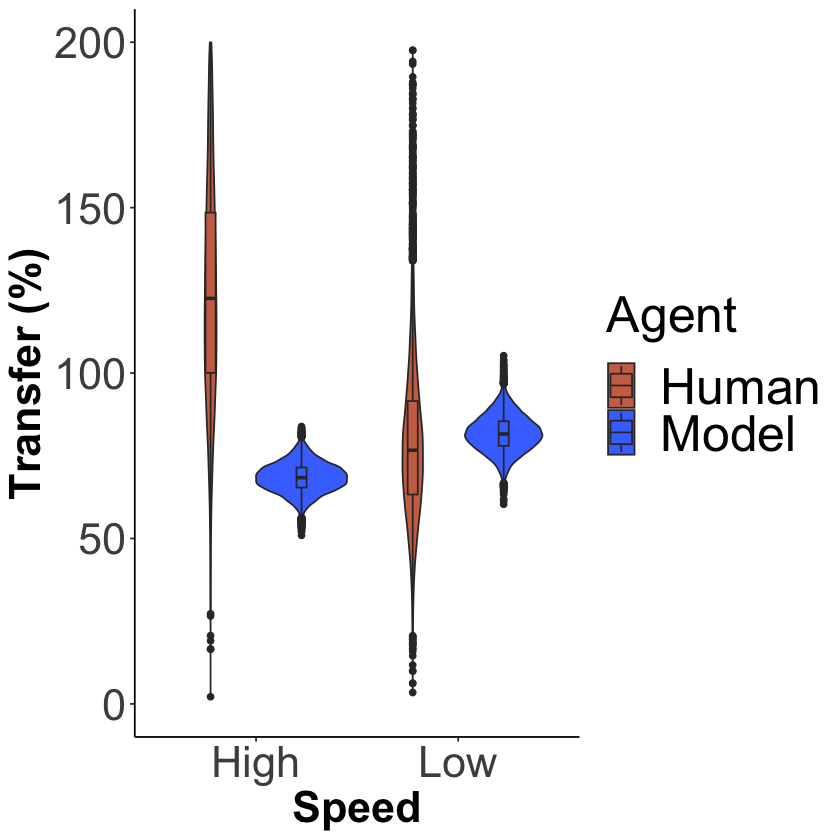

In [19]:
#Transfer - Bootstrap technique
H_Slow <- MatTr[,9]
H_Medium <- MatTr[,10]
M_Slow <- MatTr[,11]
M_Medium <- MatTr[,12]
n<-length(H_Medium)

#Transfer data frame
Agent <- c(rep('Human',n),rep('Human',n),rep('Model',n),rep('Model',n))
GameSpeed <- c(rep('Slow',n),rep('Medium',n),rep('Slow',n),rep('Medium',n))
Transfer_Perc <- c(H_Slow,H_Medium,M_Slow,M_Medium)
Tr3Boot_toPlot <- data.frame(Agent, GameSpeed, Transfer_Perc)

#Plot violin plots for Transfer dataset
p <- ggplot(Tr3Boot_toPlot, aes(x=GameSpeed, y=Transfer_Perc, fill=Agent)) + 
  geom_violin() + geom_boxplot(width=0.1,position=position_dodge(0.9)) + theme_classic() +
  scale_fill_manual(values=c("salmon3","royalblue1")) + theme_classic() +
     theme(plot.title = element_text(size=30,hjust=0.5),
     axis.text = element_text(size = 26),
     strip.text = element_text(size = 26,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=30),
     legend.text=element_text(size=30)) +
    labs(x = "Speed", y = "Transfer (%)") +
  scale_x_discrete(labels=c("High", "Low")) + ylim(0,200)
  #ggtitle("Transfer with Bootsrapping")
p
pathFig <- '../Figures/Figure6bis.png'
ggsave(pathFig,p,width=12.5,height=12)

In [20]:
t.test(H_Medium,M_Medium)
t.test(H_Slow,M_Slow)
#shapiro.test(H_Medium)


	Welch Two Sample t-test

data:  H_Medium and M_Medium
t = 3.4876, df = 9999, p-value = 0.0004895
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  54.1922 193.2875
sample estimates:
mean of x mean of y 
192.14423  68.40437 



	Welch Two Sample t-test

data:  H_Slow and M_Slow
t = -9.8316, df = 10980, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.031740 -2.023792
sample estimates:
mean of x mean of y 
 79.23828  81.76605 


In [25]:
median(H_Medium)
median(M_Medium)
median(H_Slow)
median(M_Slow)

[1] 131.174

[1] 68.44287

[1] 76.35934

[1] 81.70894

In [26]:
mean(H_Medium)
mean(M_Medium)
mean(H_Slow)
mean(M_Slow)

[1] 148.0682

[1] 68.44024

[1] 78.54053

[1] 81.79644